In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import random_split
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.models as models  
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import time
from timeit import default_timer as timer
import random


In [2]:
from pathlib import Path
import pandas as pd

data_path = Path('data')

if data_path.exists() and data_path.is_dir():
    print("Directory exists. Checking for CSV files...")
    
    train_name = pd.read_csv(data_path / 'written_name_train_v2.csv') if (data_path / 'written_name_train_v2.csv').exists() else None
    test_name = pd.read_csv(data_path / 'written_name_test_v2.csv') if (data_path / 'written_name_test_v2.csv').exists() else None
    val_name = pd.read_csv(data_path / 'written_name_validation_v2.csv') if (data_path / 'written_name_validation_v2.csv').exists() else None

    print("Loaded train, test, and validation data.")

else:
    print("Directory does not exist.")


Directory exists. Checking for CSV files...
Loaded train, test, and validation data.


In [8]:
data_path.descri

AttributeError: 'WindowsPath' object has no attribute 'describe'

Random Image Path : data\000\a01-003u.png
Image Class : 000
Image Height : 3542
Image Width : 2479


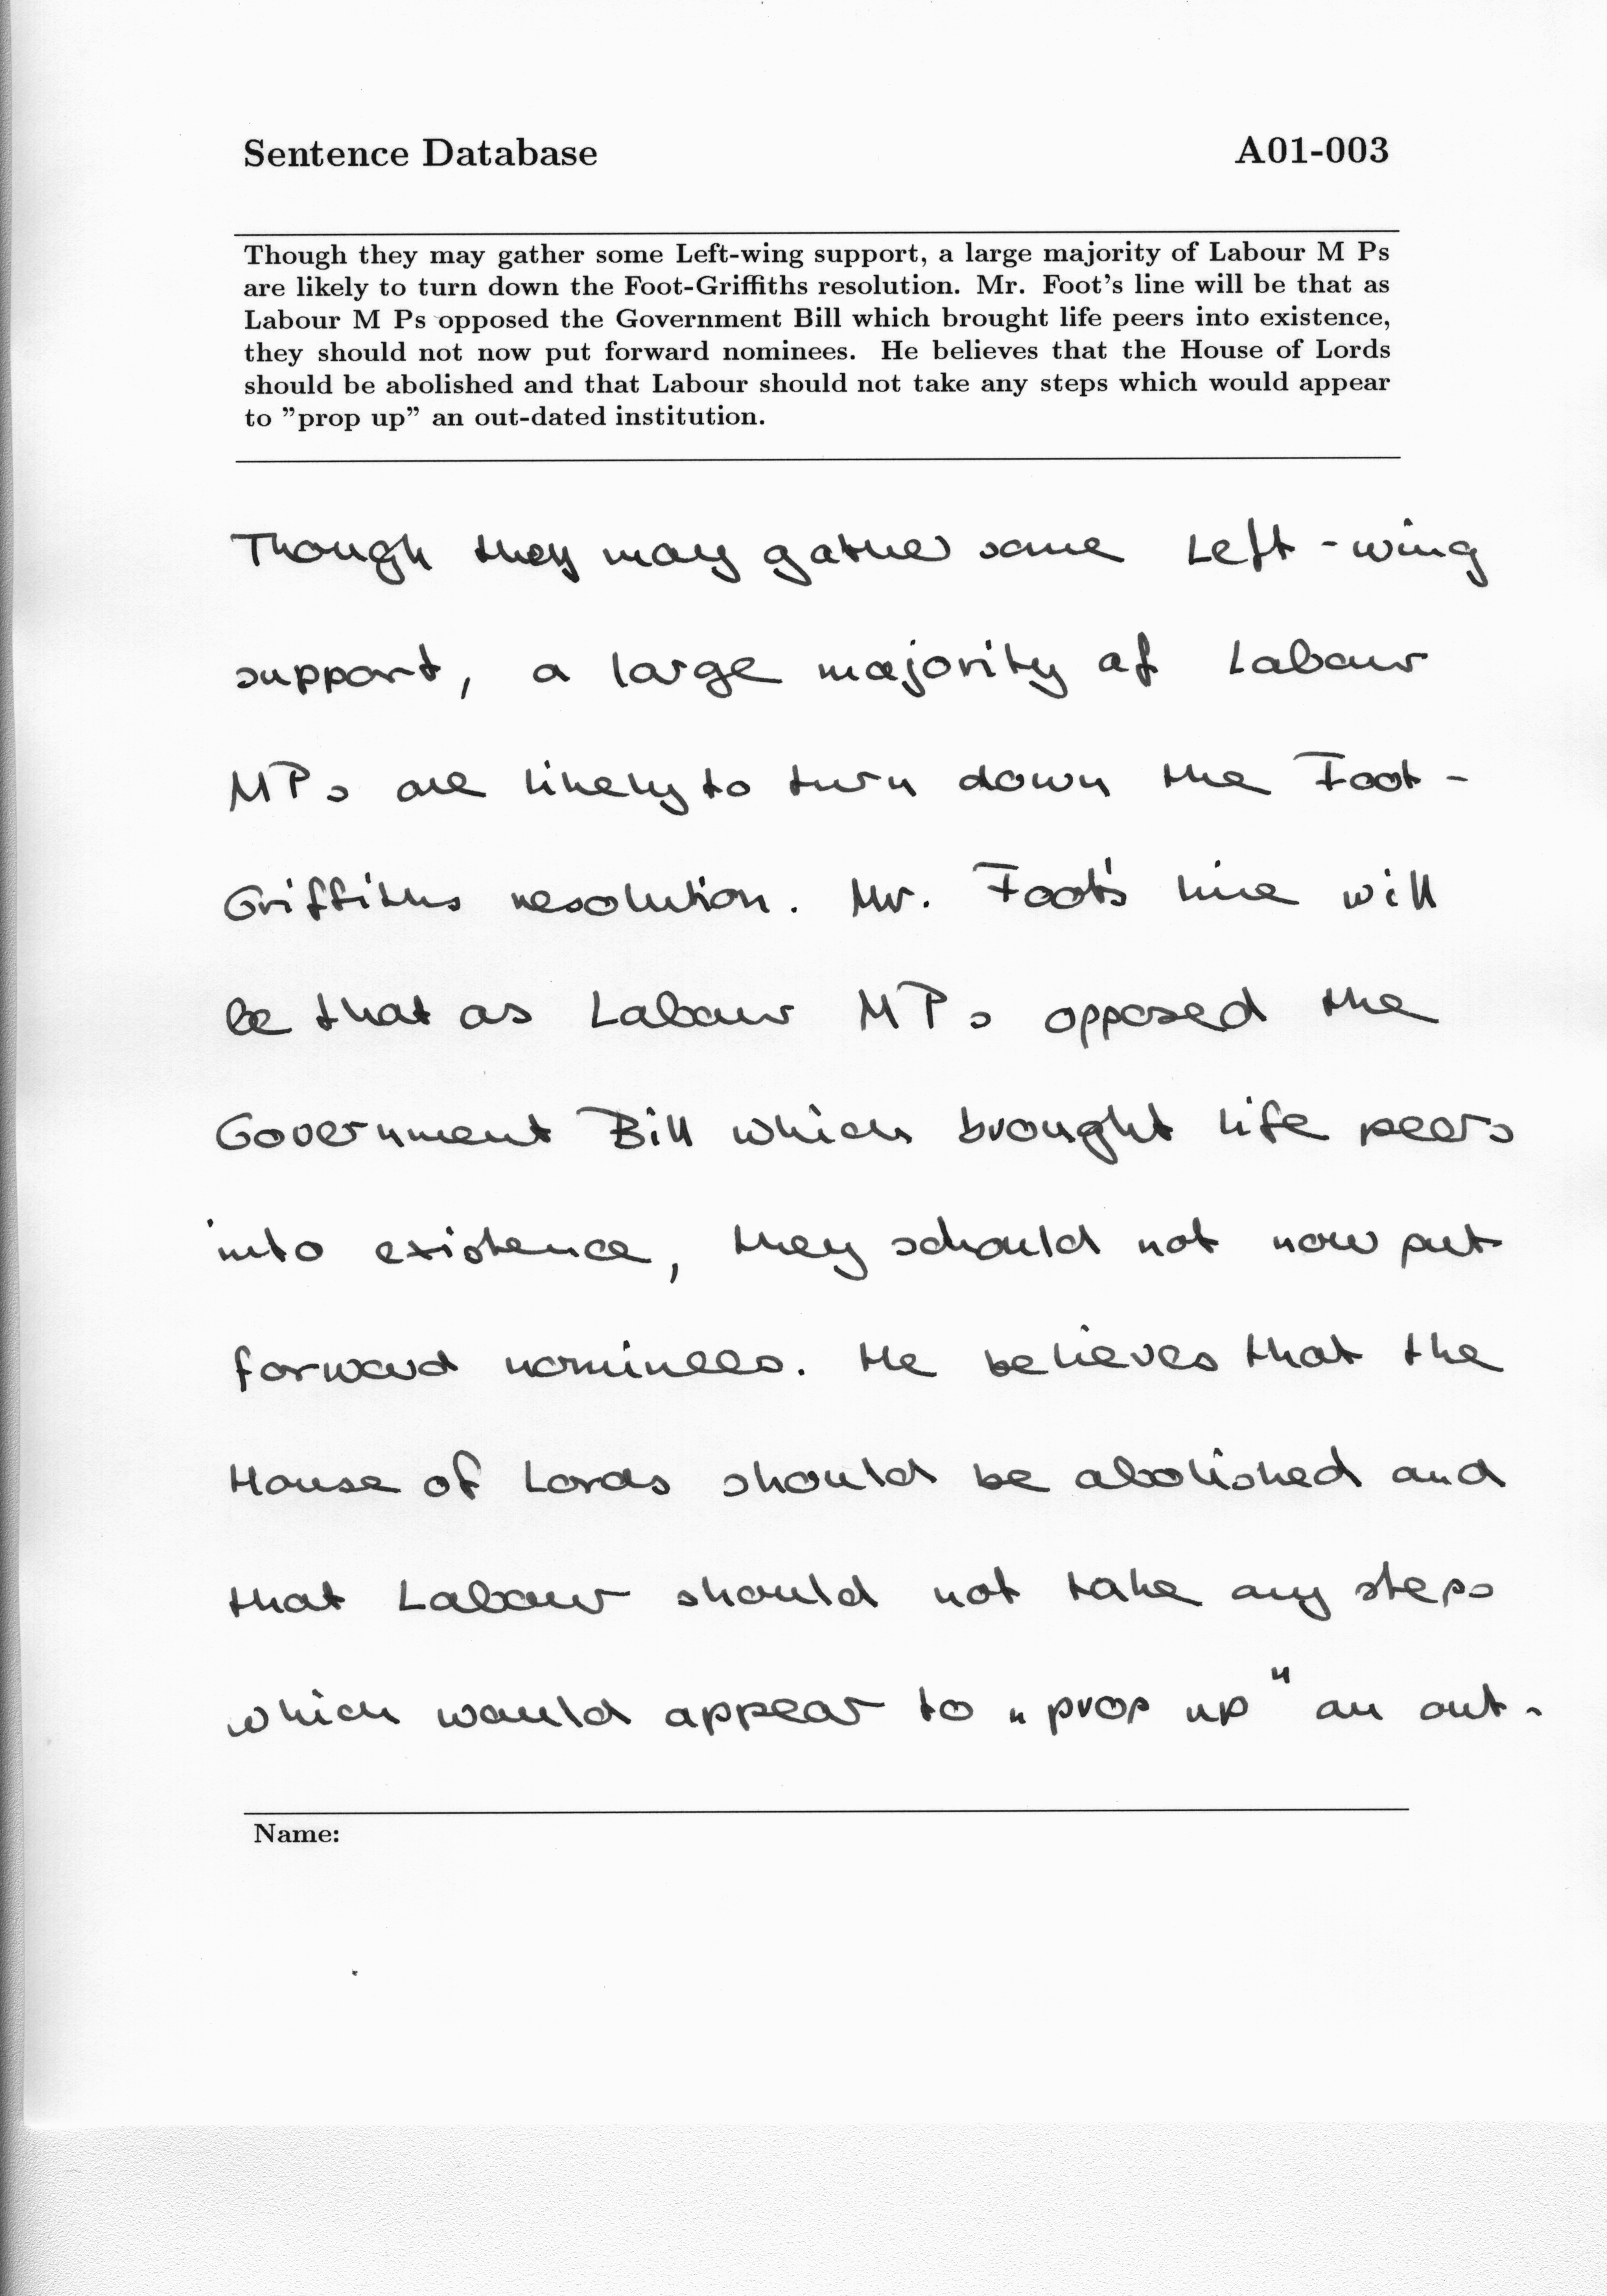

In [11]:
image_path_list = list(data_path.glob("*/*"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path : {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

In [12]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
image_transforms

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [13]:
def plot_transformed_image(image_paths,transform,n=3,seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size : {f.size}")
            ax[0].axis(False)
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize : {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class : {image_path.parent.stem}",fontsize = 16)

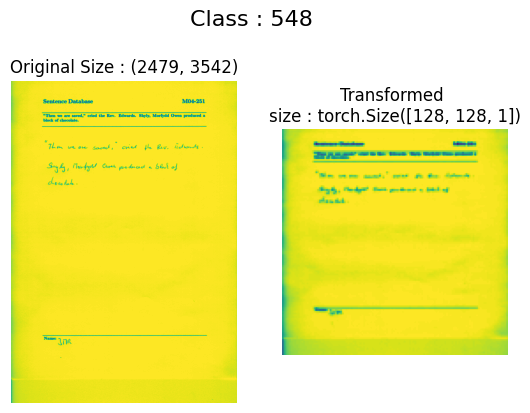

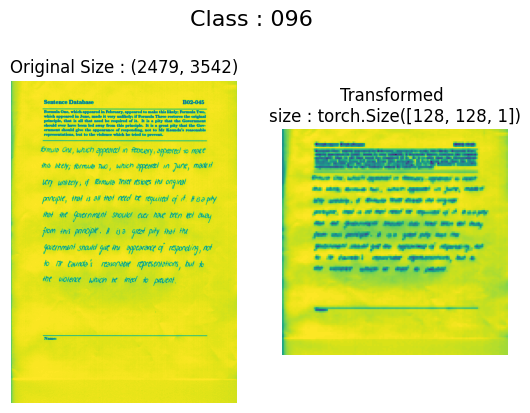

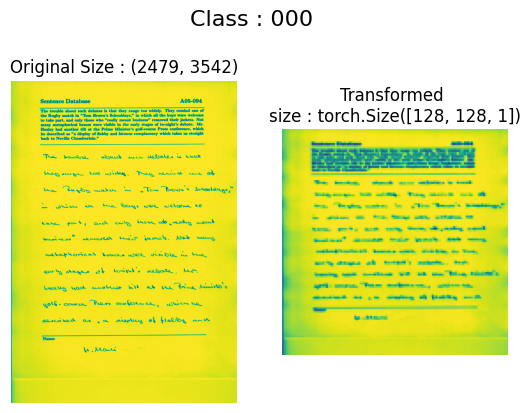

In [14]:
plot_transformed_image(image_path_list,image_transforms)

In [15]:
import os

def walk_through_dir_with_inputs_and_targets(dir_path):
    inputs = []  # To store image file paths (inputs)
    targets = []  # To store corresponding labels (targets)

    for dirpath, dirnames, filenames in os.walk(dir_path):
        num_images = len([f for f in filenames if f.endswith('.png') or f.endswith('.jpg')])
        print(f"There are {len(dirnames)} directories and {num_images} images in '{dirpath}'.")
        
        for filename in filenames:
            if filename.endswith('.png') or filename.endswith('.jpg'):
                # Assuming labels are the filename without the extension
                image_path = os.path.join(dirpath, filename)
                inputs.append(image_path)  # Store the image file path as input

                # Extracting the label from the filename (you can adjust this based on your label format)
                label = os.path.splitext(filename)[0]  # Removes the extension to use the filename as the label
                targets.append(label)

    return inputs, targets


# Example usage:
dir_path = 'data'
inputs, targets = walk_through_dir_with_inputs_and_targets(dir_path)

# Printing the first 5 inputs and targets
print("Inputs (image file paths):", inputs[:5])
print("Targets (labels):", targets[:5])


There are 657 directories and 0 images in 'data'.
There are 0 directories and 59 images in 'data\000'.
There are 0 directories and 2 images in 'data\001'.
There are 0 directories and 1 images in 'data\002'.
There are 0 directories and 2 images in 'data\003'.
There are 0 directories and 1 images in 'data\004'.
There are 0 directories and 2 images in 'data\005'.
There are 0 directories and 1 images in 'data\006'.
There are 0 directories and 2 images in 'data\007'.
There are 0 directories and 2 images in 'data\008'.
There are 0 directories and 2 images in 'data\009'.
There are 0 directories and 2 images in 'data\010'.
There are 0 directories and 2 images in 'data\011'.
There are 0 directories and 2 images in 'data\012'.
There are 0 directories and 3 images in 'data\013'.
There are 0 directories and 2 images in 'data\014'.
There are 0 directories and 1 images in 'data\015'.
There are 0 directories and 3 images in 'data\016'.
There are 0 directories and 3 images in 'data\017'.
There are 0 d

In [17]:
dir_path = 'data'

In [20]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from pathlib import Path

# Define the data path
data_path = Path('data')

# Define your transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset using the defined data path
train_data = datasets.ImageFolder(root=data_path, transform=transform)

# Split the dataset into training, validation, and testing
total_size = len(train_data)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # remaining 10% for testing

# Perform the random split
train_dataset, val_dataset, test_dataset = random_split(
    train_data, [train_size, val_size, test_size]
)

# Length of each split
len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)

print(f'Training set size: {len_train}, Validation set size: {len_val}, Test set size: {len_test}')


Training set size: 1231, Validation set size: 153, Test set size: 155


In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from pathlib import Path

# Define the data path
data_path = Path('data')

# Define your transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((256, 64)),  # Resize images to 256x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset using the defined data path
train_data = datasets.ImageFolder(root=data_path, transform=transform)

# Split the dataset into training, validation, and testing
total_size = len(train_data)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # remaining 10% for testing

# Perform the random split
train_dataset, val_dataset, test_dataset = random_split(
    train_data, [train_size, val_size, test_size]
)

# Length of each split
len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)

print(f'Training set size: {len_train}, Validation set size: {len_val}, Test set size: {len_test}')

# Initialize lists to hold image data
train_x = []
val_x = []
test_x = []

# Function to extract images from a dataset
def extract_images(dataset):
    images = []
    for img, _ in dataset:  # Each item is a tuple (image, label)
        images.append(img.numpy())  # Convert tensor to numpy array
    return np.array(images)

# Populate train_x, val_x, and test_x with image data
train_x = extract_images(train_dataset)
val_x = extract_images(val_dataset)
test_x = extract_images(test_dataset)

# Reshape the image arrays
train_x = train_x.reshape(-1, 256, 64, 1)  # Change dimensions as required
val_x = val_x.reshape(-1, 256, 64, 1)
test_x = test_x.reshape(-1, 256, 64, 1)

# Print the shapes of the reshaped arrays
print(f'Train x shape: {train_x.shape}')
print(f'Validation x shape: {val_x.shape}')
print(f'Test x shape: {test_x.shape}')


Training set size: 1231, Validation set size: 153, Test set size: 155
Train x shape: (3693, 256, 64, 1)
Validation x shape: (459, 256, 64, 1)
Test x shape: (465, 256, 64, 1)


In [27]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input name
num_characters = len(alphabets) + 1 # the plus one is to account for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted names

def name_to_num(name):
    name_num = []
    for ch in name:
        name_num.append(alphabets.find(ch))
    return np.array(name_num)

def num_to_name(num):
    name = ""
    for ch in num:
        if ch == -1: # CTC blank
            break
        else:
            name += alphabets[ch]
    return name

In [28]:
def ctc_lambda_func(args):
    y_pred, names, input_length, name_length = args
    
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(names, y_pred, input_length, name_length)

input_data = Input(shape=(256, 64, 1), name='input')
    
# CNN
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner)
    
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max2')(inner)
inner = Dropout(0.3)(inner)
    
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1,2), name='max3')(inner)
inner = Dropout(0.3)(inner)
    
# CNN to RNN
inner = Reshape(target_shape = ((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)
    
# RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)
    
# Output
inner = Dense(num_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
    
model = Model(inputs=input_data, outputs=y_pred)

# Now include the ctc loss function and compile
names = Input(name='gtruth_names', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
name_length = Input(name='name_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, names, input_length, name_length])
model_final = Model(inputs=[input_data, names, input_length, name_length], outputs=ctc_loss)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

ValueError: Argument(s) not recognized: {'lr': 0.0001}

In [ ]:
model_final.fit(x = [train_x, train_y, train_input_len, train_name_len], y=train_output, validation_data = ([val_x, val_y, val_input_len, val_name_len], val_output), epochs=60, batch_size=128)